In [15]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
lemmatizer = WordNetLemmatizer()

C:\Users\mac\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [16]:

# this whole cell will be automated when pip installed using os library. will modify when deploying to Pypi

import ast
import numpy as np

def create_ci_lexicon(lexicon_file):
    
    """
    Takes in an inital lexicon with information on how the final values was derived.
    Outputs confidence score for each individual word.
    """
    
    df = pd.read_csv(lexicon_file, encoding='cp437', header=None)
    
    def descriptive(x):
        return np.std(ast.literal_eval(x))
    
    df['std_dev'] = df[3].str.strip("'").apply(descriptive)
    
    basis = df.std_dev.mean() + 1.5 * df.std_dev.std()
    
    def normalize_conf(x):
        return (x - basis) / basis
    
    df['norm_conf'] = df.std_dev.apply(normalize_conf)
    
    return dict(zip(df[[0, 'norm_conf']][0].values, (1 - (df.norm_conf.rank() / df.norm_conf.rank().max()))))

ci_lexicon = create_ci_lexicon('vader_lexicon.csv')
lexicon = dict(zip(pd.read_csv('vader_lexicon.csv', encoding='cp437', header=None)[[0, 1]].values.T[0], pd.read_csv('vader_lexicon.csv', encoding='cp437', header=None)[[0, 1]].values.T[1]))

In [17]:
#Here are a list of words that, when preceding, require us to inverse our score. 
#"I like Apple" has a score of 1.5, but "I don't like Apple" would have a score of -1.5 because of the negation
negate = \
    ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt",
     "ain't", "aren't", "can't", "couldn't", "daren't", "didn't", "doesn't",
     "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither",
     "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
     "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
     "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
     "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
     "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"]

boost = \
    ['absolutely', 'amazingly', 'awfully', 'completely', 'considerably', 'decidedly', 'deeply', 'effing', 'enormously',
     'entirely', 'especially', 'exceptionally', 'extremely', 'fabulously', 'flipping', 'flippin', 'fricking', 'frickin',
     'frigging', 'friggin', 'fully', 'fucking', 'greatly', 'hella', 'highly', 'hugely', 'incredibly', 'intensely', 'majorly',
     'more', 'most', 'particularly', 'purely', 'quite', 'really', 'remarkably', 'so', 'substantially',
     'thoroughly', 'totally', 'tremendously', 'uber', 'unbelievably', 'unusually', 'utterly', 'very', 'almost', 'barely']

In [18]:
class PreprocessText(object):
    """
    Sentiment relevant text properties. 
    """

    def __init__(self, text):

        self.text = text
        self.clean_text = self._clean_text()

    def _clean_text(self):

        wordz = self.text.split()

        lemmatizer = WordNetLemmatizer()
        words = []
        for word in wordz:
            words.append(lemmatizer.lemmatize(word))

        return words

In [95]:
class Sentiment(object):
    """
    Sentiment Analyzer
    """


    def __init__(self):

        self.lexicon = lexicon
        self.negate = negate
        self.ci_lexicon = ci_lexicon
            
    def score(self, text):

        words = PreprocessText(text).clean_text
        sentiments = []
        confidences = []
        for item in words:
            sentiments, confidences = self.sentiment_polarity(item, sentiments, confidences, words)
        score_interval = self.final_calculation(sentiments, confidences)
        
        return {'score': score_interval[0], 'confidence_interval': score_interval[1]}
        
    def sentiment_polarity(self, item, sentiments, confidences, words):
        #Checks the average sentiment score by querying our lexicon
        item_lowercase = item.lower()
        if item_lowercase in self.lexicon:
            weight = self.lexicon[item_lowercase] / 5 
            final_weight = self.negation_check(words, item, weight)
            confidence_score = self.ci_lexicon[item_lowercase]
            confidence_calc = self.confidence_calc(final_weight, confidence_score)
            sentiments.append(final_weight)
            confidences.append(confidence_calc)
        return sentiments, confidences
    
    
    def final_calculation(self, sentiments, confidences):
        #Applies all final calculations to get the final sentiment score
        
        if len(sentiments) == 0:
            final_calc = 0
            return final_calc, (0, 0)
        else:
            final_calc = sum(sentiments) / len(sentiments)
        
        count = 0
        upper = 0
        lower = 0
        for interv in confidences:
            upper += interv[1]
            lower += interv[0]
            count += 1
        
        return final_calc, (lower/count, upper/count)
    
    def negation_check(self, words, item, weight):
        #Checks to see if there is a negation word in the words
        #"I love apples = 3.2"
        #"I don't love apples = -3.2"
        neg_coef = 1
        lexicon_index = words.index(item)
        preceding_word = words[lexicon_index - 1]
        if preceding_word in self.negate:
            neg_coef = -1
        final_weight = weight * neg_coef
        return final_weight
    
    def confidence_calc(self, final_weight, confidence_score): 
        
        if final_weight >= 0:
            upper = final_weight + (1 - confidence_score) * final_weight
            lower = final_weight - (1 - confidence_score) * final_weight
        else: 
            lower = final_weight + (1 - confidence_score) * final_weight
            upper = final_weight - (1 - confidence_score) * final_weight
        return (lower, upper)
        
    

In [96]:
t = """Turning to the wholesale channel, revenue was down 4% related to the shift in timing of shipments
as we said last quarter. As stated earlier, our brand is performing well at both Neiman Marcus and Nordstrom
as well as across our specialty retail and third-party e-commerce partners globally"""

In [97]:
%%time

sid = SentimentIntensityAnalyzer()

print(sid.polarity_scores(t))

{'neg': 0.0, 'neu': 0.916, 'pos': 0.084, 'compound': 0.4939}
Wall time: 19.9 ms


In [98]:
%%time
analyzer = Sentiment()
print(analyzer.score(t))

{'score': 0.22000000000000003, 'confidence_interval': (0.06074364773180793, 0.3792563522681921)}
Wall time: 998 µs


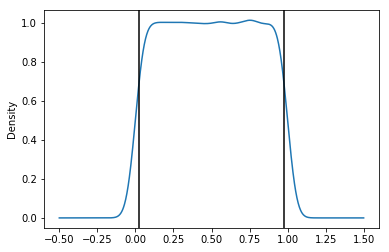

In [99]:
import matplotlib.pyplot as plt
pd.Series(ci_lexicon).plot.density()
plt.axvline(pd.Series(ci_lexicon).quantile(.975), color='black')
plt.axvline(pd.Series(ci_lexicon).quantile(.025), color='black');

In [1]:
!python -m pip install --upgrade pip
!pip install seaborn==0.9.0

Requirement already up-to-date: pip in c:\users\mac\anaconda3\lib\site-packages (19.1.1)


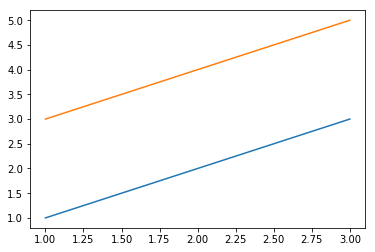

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
# add plotting functionality to our sentiment model.
x = [1,2,3]
y = [1,2,3]
z = [3,4,5]
sns.lineplot(x, y)
sns.lineplot(x, z);

In [101]:
import pandas as pd
df = pd.read_csv('trading-tweets.csv')

In [102]:
df.head()

,Unnamed: 0,text,time
0,0,"Hoy nos toca irnos en negativo 1,25. Un mercad...",6/13/2019 17:04
1,1,🏄 #GBPUSD Head &amp; Shoulders Pattern Challe...,6/13/2019 17:04
2,2,$SPX #stock $AVGO highlights the very short li...,6/13/2019 17:03
3,3,"As we always said, there are traders and then ...",6/13/2019 17:03
4,4,RT @EarnsBit: Hello Community!\r\nWe are happy...,6/13/2019 17:03


In [103]:
model = Sentiment()
def vectorized_sentiment(text):
    try:
        return model.score(text)
    except:
        return 0

df['scores'] = df.text.apply(vectorized_sentiment)

In [104]:
bitcoin = df[(df.text.str.lower().str.contains('btc') | df.text.str.lower().str.contains('bitcoin'))]

In [105]:
bitcoin = bitcoin[bitcoin.scores.apply(lambda x: x['score']) != 0]

In [106]:
bitcoin.time = pd.to_datetime(bitcoin.time)

In [107]:
df = bitcoin.copy()

C:\Users\mac\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


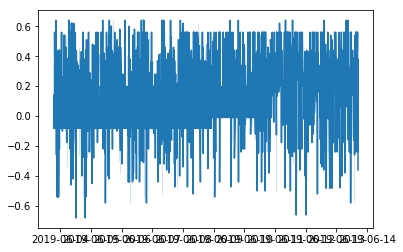

In [108]:
x = df.time.values
y = df.scores.apply(lambda x: x['score']).values

sns.lineplot(x=x, y=y)

In [109]:
df['sentiment_score'] = df.scores.apply(lambda x: x['score'])
df['lower_bound'] = df.scores.apply(lambda x: x['confidence_interval'][0])
df['upper_bound'] = df.scores.apply(lambda x: x['confidence_interval'][1])

In [110]:
grouped = df.groupby(df.time.dt.date).mean()

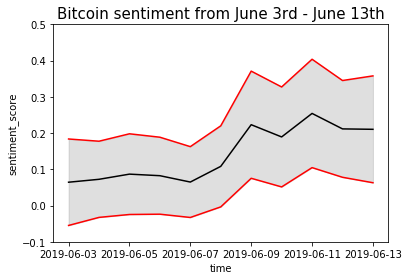

In [176]:
grouped.head()

z = pd.Series((pd.read_csv('BTC-USD.csv').Close.values - pd.read_csv('BTC-USD.csv').Close.values.mean()) / pd.read_csv('BTC-USD.csv').Close.values.mean()).values

sns.lineplot(x=grouped.index, y=grouped.lower_bound, color='red')
sns.lineplot(x=grouped.index, y=grouped.upper_bound, color='red')
#sns.lineplot(x=grouped.index, y=z)
plt.ylim(-.1, .5)
plt.fill_between(grouped.index, y1=grouped.lower_bound, y2=grouped.upper_bound, color='gray', alpha=.25)
sns.lineplot(x=grouped.index, y=grouped.sentiment_score, color='black')
plt.title('Bitcoin sentiment from June 3rd - June 13th', fontsize=15);

In [171]:
grouped

,sentiment_score,lower_bound,upper_bound,scores_vader,combined
time,,,,,
2019-06-03,0.064412,-0.054878,0.183701,0.080853,0.072632
2019-06-04,0.072461,-0.032634,0.177556,0.047781,0.060121
2019-06-05,0.086713,-0.024614,0.198039,0.074002,0.080357
2019-06-06,0.082408,-0.023801,0.188617,0.073222,0.077815
2019-06-07,0.064871,-0.032857,0.162598,0.060865,0.062868
2019-06-08,0.108183,-0.003651,0.220018,0.111735,0.109959
2019-06-09,0.223137,0.075285,0.370989,0.288345,0.255741
2019-06-10,0.189350,0.051441,0.327258,0.258938,0.224144
2019-06-11,0.254223,0.104691,0.403756,0.397406,0.325815


In [117]:
df.sentiment_score.describe()

count    2617.000000
mean        0.130956
std         0.247411
min        -0.680000
25%        -0.080000
50%         0.160000
75%         0.300000
max         0.640000
Name: sentiment_score, dtype: float64

In [118]:
pd.Series((pd.read_csv('BTC-USD.csv').Close.values - pd.read_csv('BTC-USD.csv').Close.values.mean()) / pd.read_csv('BTC-USD.csv').Close.values.mean()).values

array([ 0.02243007, -0.03263468, -0.01829332, -0.01626852,  0.00833561,
       -0.00033954, -0.03692251,  0.01065026, -0.0024135 ,  0.02994599,
        0.03551014])

In [119]:
np.corrcoef(grouped.sentiment_score, z)

array([[1.        , 0.20088342],
       [0.20088342, 1.        ]])

In [120]:
Sentiment().score('i really love cats')

{'score': 0.64,
 'confidence_interval': (0.6263349740588001, 0.6536650259411999)}

In [156]:
model = Sentiment()
def vectorized_sentiment(text):
    try:
        return sid.polarity_scores(text)['compound']
    except:
        return 0

df['scores_vader'] = df.text.apply(vectorized_sentiment)

In [158]:
grouped = df.groupby(df.time.dt.date).mean()

In [163]:
np.corrcoef(grouped.scores_vader, z)

array([[1.        , 0.34705013],
       [0.34705013, 1.        ]])

In [164]:
grouped['combined'] = (grouped.scores_vader + grouped.sentiment_score) / 2

In [166]:
np.corrcoef(grouped.combined, z)

array([[1.        , 0.29610397],
       [0.29610397, 1.        ]])

In [181]:
df.text.str.split()

55       [Trading, Bitcoin, -, Broke, Out, as, Expected...
71       [RT, @CoinSense101:, $NEO, is, about, to, brea...
83       [#RT, BitCoinAlertBot:, #BTC, has, risen, by, ...
122      [$NEO, is, about, to, break, out, ,, Targets, ...
134      [RT, @CopilotThe:, #Bitcoin, putting, a, lot, ...
145      [RT, @murthaburke:, From, June, 1st, to, July,...
160      [RT, @CreditTerra:, Credit, Trading, Competiti...
181      [$BTC_F, (Bitcoin, Futures, on, CME), High, Po...
182      [👉@BravadoTrading, has, the, right, attitude.,...
184      [RT, @murthaburke:, From, June, 1st, to, July,...
204      [Let’s, go, $WAVES,, need, some, volume, but, ...
205      [No, one, believed, in, Bitcoin, at, this, tim...
227      [Top, 5, #cryptocurrencies, Alert, Time:, 2019...
237      [Bitcoin, Holders', Profits, Equal, that, of, ...
295      [Bitcoin, ETF, approval, delayed, again?!, Tel...
321      [RT, @murthaburke:, From, June, 1st, to, July,...
339      [Top, 5, #cryptocurrencies, Alert, Time:, 2019.

In [173]:
analyzer.score('hi cole')

{'score': 0, 'confidence_interval': (0, 0)}

In [196]:
vocab = {}

def loop_words(lst_of_words):
    
    for word in lst_of_words:
        try:
            vocab[word] += 1
            
        except:
            vocab[word] = 1
    
df.text.str.lower().str.split().apply(loop_words)

55       None
71       None
83       None
122      None
134      None
145      None
160      None
181      None
182      None
184      None
204      None
205      None
227      None
237      None
295      None
321      None
339      None
372      None
387      None
471      None
483      None
530      None
532      None
588      None
621      None
650      None
675      None
685      None
712      None
720      None
         ... 
45285    None
45288    None
45319    None
45325    None
45348    None
45352    None
45376    None
45392    None
45398    None
45446    None
45450    None
45456    None
45459    None
45467    None
45471    None
45480    None
45494    None
45504    None
45505    None
45509    None
45525    None
45545    None
45577    None
45597    None
45600    None
45601    None
45644    None
45678    None
45712    None
45717    None
Name: text, Length: 2617, dtype: object

In [206]:
word_counts = pd.DataFrame({'words':list(vocab.keys()), 'counts': list(vocab.values())}).sort_values('counts', ascending=False)

In [207]:
word_counts

,counts,words
2,2133,-
1309,1448,$
2922,1389,%)
39,1019,in
29,1013,$btc
40,829,the
15,751,rt
31,697,#bitcoin
30,674,$eth
279,655,$xrp
